## Building The Country Page Widgets

Charlie has added the following dataset to the **PRODUCTION** API for the construction of the new country pages widgets. This notebook details how to query these datasets to create a the required widgets.


Note: many queries will be repeated, but the data used in different ways, so we should cache the responses for re-use.

```
{'dataset': '499682b1-3174-493f-ba1a-368b4636708e'}
```


https://production-api.globalforestwatch.org/v1/query/?sql=SELECT polyname, year_data.year, sum(year_data.area_loss) as sum FROM data WHERE polyname = 'wdpa'  and iso = 'BRA' GROUP BY polyname, iso, nested(year_data.year)


In [2]:
import requests
import requests_cache
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
requests_cache.install_cache('demo_cache')

Testing basic queries

**notes**

* New table structure includes `bound1-4` which provide an additional attribute to group by

```
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT polyname, count(*) FROM data WHERE iso = 'BRA' and thresh = 30 GROUP BY polyname
```

This one table should be enough to generate data for areas of interest from admin0 to admin 2 level on its own.

In [3]:
ds = '499682b1-3174-493f-ba1a-368b4636708e'  # ADMIN 2 level data

In [4]:
# Example of what is in the data tables and how to simply read them:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = (f"SELECT * FROM {ds} WHERE iso = 'BRA' AND thresh = 30 AND polyname = 'plantations' LIMIT 4")
#sql = (f"SELECT polyname, count(*) FROM {ds} WHERE iso = 'BRA' and thresh = 30 GROUP BY polyname")
#sql = (f"SELECT * FROM {ds} WHERE iso = 'BRA' AND thresh = 30 AND polyname = 'bra_biomes' LIMIT 1")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
r.json()

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+%2A+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27plantations%27+LIMIT+4
Status: 200


{'data': [{'_id': 'AWBPJIgaJ0wPeEVRbOPk',
   'adm1': 21,
   'adm2': 3993,
   'area_extent': 140.273315496,
   'area_gadm28': 13213.6374505,
   'area_gain': 1224764.65884,
   'area_poly_aoi': 280.27883318,
   'bound1': 'Large industrial plantation',
   'bound2': 'Wood fiber / timber',
   'bound3': -9999,
   'bound4': -9999,
   'iso': 'BRA',
   'polyname': 'plantations',
   'thresh': 30,
   'year_data': [{'area_loss': 0.136910908574,
     'emissions': 17.3876853889,
     'year': 2001},
    {'area_loss': 0.13691592368, 'emissions': 14.7869197574, 'year': 2002},
    {'area_loss': 0, 'emissions': 0, 'year': 2003},
    {'area_loss': 0.0684574299642,
     'emissions': 5.887338976919999,
     'year': 2004},
    {'area_loss': 0, 'emissions': 0, 'year': 2005},
    {'area_loss': 0, 'emissions': 0, 'year': 2006},
    {'area_loss': 0, 'emissions': 0, 'year': 2007},
    {'area_loss': 0.0684598612663,
     'emissions': 8.146723490689999,
     'year': 2008},
    {'area_loss': 0, 'emissions': 0, 'year'

The `polyname` attribute in the data indicates the geometry used in the intersection. E.g. `polyname`:`gadm28` means that the GADM28 polygons alone were used, therefore `area_extent` would be the value of the Hansen 2010 tree cover extent within a particular gadm28 geometry.

Charlie has used a convention of mutliple underscores to indicate when data has multiple intersects. The rule is as follows:
* All data are intersected with the gadm28
* Some data are intersected with gadam + something else, in that case it takes the name of the something else, e.g. plantations
* some data are intersected with multiple gadam + multiple other data sources, in that case, the data sources are seperated by a dunder (double underscore) in the `polyname`. E.g. `primary_forest__landmark` are the gadam28 + primary forest data + landmark 

In [13]:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = (f"SELECT polyname FROM {ds} WHERE iso = 'BRA' and thresh = 0 GROUP BY polyname")
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
for row in r.json().get('data'):
    print(row.get('polyname'))

https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+and+thresh+%3D+0+GROUP+BY+polyname
Status: 200
gadm28
bra_biomes
mining
plantations
wdpa
plantations__mining
primary_forest
primary_forest__mining
primary_forest__wdpa
plantations__wdpa
ifl_2013
ifl_2013__wdpa
ifl_2013__mining
landmark
primary_forest__landmark
plantations__landmark


Also of note, is the `bound1-4` attributes, which are 

```
   'bound1': 'Large industrial plantation',
   'bound2': 'Wood fiber / timber',
   'bound3': -9999,
   'bound4': -9999,
   
```

These hold extra properties of a dataset which can be used in group-by statements, e.g. plantation data has been split into species type. 

Finally, another key property is the `area_poly_aoi`, which should hold the total area (ha) of the shape used to make the intersection. E.g., the sum of the `polyname` = gadm28 `area_poly_aoi` values should equal the total land area of a selected ROI. 


# Obtain metadata for admin0 to admin2 level

Retrieve json mappings of id values (e.g. iso codes or integers) for admin0 to admin2 level, and map them to english names for selectors and resources to build dynamic sentences.

In [46]:
def get_admin0_json(urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """return an alphabetical json of mappings of iso and country names
    e.g.
    [{'iso': 'AFG', 'name': 'Afghanistan'},
     {'iso': 'XAD', 'name': 'Akrotiri and Dhekelia'},
     {'iso': 'ALA', 'name': 'Åland'},
     ...
    ]
    
    """
    sql = ("SELECT iso, country as name FROM umd_nat_staging "
            "GROUP BY iso, name "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})
    return r.json().get('rows', None)
 

def get_admin1_json(iso, urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """return an alphabetical json of mappings of admin1 for a country
    e.g. for iso='GBR'
        [{'adm1': 1, 'name': 'England'},
         {'adm1': 2, 'name': 'Northern Ireland'},
         {'adm1': 3, 'name': 'Scotland'},
         {'adm1': 4, 'name': 'Wales'}]
    """
    sql = ("SELECT id1 as adm1, region as name "
            "FROM umd_subnat_staging "
            f"WHERE iso = '{iso}' "
            "and year = 2001 "
            "and thresh = 30 "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})
    return r.json().get('rows', None)
   

def get_admin2_json(iso, adm1, urlCarto="https://wri-01.carto.com/api/v2/sql"):
    """ 
    e.g. response for iso='GBR' adm1=1
    [{'adm2': 1, 'name': 'Barking and Dagenham'},
     {'adm2': 2, 'name': 'Bath and North East Somerset'},
     ...
     ]

    """
    sql = ("SELECT id_2 as adm2, name_2 as name "
            "FROM gadm28_adm2 "
            f"WHERE iso = '{iso}' "
            f"AND id_1 = {adm1} "
            "ORDER BY name "
          )
    r = requests.get(urlCarto, params={"q": sql})    
    return r.json().get('rows', None)

In [47]:
tmp = get_admin0_json()
iso_to_countries = {}
for row in tmp:
    iso_to_countries[row.get('iso')] = row.get('name')

# Get info on an areas shape

Use the Geostore service to find the geometry, bounding box or additional info on a given `iso` or `iso/admin1` area if required (e.g. for centering the map).

Note - if similar info is needed for admin2 areas I will have to go back and create a query based on a Carto table, as admin-2 level data does not exist in the geostore service yet.

In [16]:
iso = "GBR"
adm1 = None 

if not adm1:
    print("returning admin-0 level geostore")
    url = f"https://api.resourcewatch.org/v1/geostore/admin/{iso}"
else:
    print("returning admin-1 level geostore")
    url = f"https://api.resourcewatch.org/v1/geostore/admin/{iso}/{adm1}"
    
r = requests.get(url)
print(r.url)
roi = r.json()

print(roi.get('data', None).get('attributes', None).keys())
roi.get('data').get('attributes').get('bbox')  #e.g. of getting the bounding box of a ROI

returning admin-0 level geostore
https://api.resourcewatch.org/v1/geostore/admin/GBR
dict_keys(['geojson', 'hash', 'provider', 'areaHa', 'bbox', 'lock', 'info'])


[-13.6913900375365, 49.8654174804688, 1.76416802406322, 60.8458213806153]

In [17]:
def create_bounding_poly(bbox):
    """Create a bounding polygon from a returned bbox of the geostore service
        (- the old api produced shapes in this format).
    """
    lat1, lon1, lat2, lon2  = bbox
    return [[lat1,lon1], [lat1,lon2],[lat2,lon2],[lat2,lon1] ,[lat1,lon1]]

In [18]:
create_bounding_poly(roi.get('data').get('attributes').get('bbox'))

[[-13.6913900375365, 49.8654174804688],
 [-13.6913900375365, 60.8458213806153],
 [1.76416802406322, 60.8458213806153],
 [1.76416802406322, 49.8654174804688],
 [-13.6913900375365, 49.8654174804688]]

# Set up global (scope) data sources for the Country Widgets 

There is some work that needs to be done in populating the Location menu, not all options should be always available: some of them will need to be iso dependent. E.g. `Biomes` should only appear in the menu if the ISO is set to `BRA`


In [10]:
polynames = {
                'All Region':'gadm28',
                'Biomes':'bra_biomes',
                'Mining':'mining',
                'Protected Areas':'wdpa',
                'Primary Forests':'primary_forest',
                'Mining in Primary Forests':'primary_forest__mining',
                'Protected Areas in Primary Forests':'primary_forest__wdpa',
                'Intact Forest Landscapes':'ifl_2013',
                'Protected Areas in Intact Forest Landscapes':'ifl_2013__wdpa',
                'Mining in Intact Forest Landscapes':'ifl_2013__mining',
                'Indigenous Lands':'landmark',
                'Indigenous Lands in Primary Forests':'primary_forest__landmark',
                'Plantations':'plantations',
                'Mining in Plantation Areas':'plantations__mining',
                'Protected areas in Plantations':'plantations__wdpa',
                'Indigenous Lands in Plantations':'plantations__landmark',
            }

# Tree cover widget

The default view for the tree cover widget should be for 'All Region'.
We provide a mapping between the text to select in the Location drop-down and the dataset IDs that need to be called in conjunction with a specific selection.


For the default  "All Region" location, we will need to show 3 slices in the donut chart:
    * Tree plantations
    * Natural forest (tree cover 2010 - tree plantations)
    * Non-forest (total area - tree cover 2010)

We show how to calculate this below.

**BUT**

If other Locations are selected, (e.g. Protected Areas), we need a different donut chart. One with less data (only tree cover, and non-forest).

    * Tree cover 
    * Non-forest



*Notes: below this line are extra notes not needed for Front-end dev*

- adm0 = BRA, adm1 = 4  is Amazonas
- adm0 = BRA, adm1 = 4, adm2 = 141 is Amaturá  (many forests)
- adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres
- adm0 = BRA, adm1 = 14, adm2 = 2404 is Para, Altamira 
- adm0 = BRA, adm1 = 16, adm2 = 3135 - largest area of plantations (Turning this on seems to reveal a bug)


In [20]:
# VARIABLES FOR TREE COVER WIDGET
ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
adm0 = 'BRA'
threshold = 30
adm1 = None
adm2 = None
location = 'All Region'  

In [21]:
def extent_queries(p_name, adm0, adm1=None, adm2 = None, threshold=30):
    if adm2:
        print('Request for adm2 area')
        sql = (f"SELECT SUM(area_extent) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               "AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area_extent) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT SUM(area_extent) as value, "
               f"SUM(area_gadm28) as total_area "
               f"FROM data "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{p_name}'")
        return sql

In [22]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 
        
print(areaId_to_name)

None


In [23]:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = extent_queries(p_name=polynames[location], adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")

try:
    total_area = r.json().get('data')[0].get('total_area')
except:
    total_area = None
print(f"total area = {total_area} ha")

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None Gadm28 Tree cover extent = 519187505.155631 ha
total area = 850033236.0091553 ha


** Gather PLANTATION data also if needed  **

In [24]:
# For some locations we will also need to retrieve an area for plantations
# This is the area of UMD forest cover intersecting tree plantations at admin2 level

if location in ['All Region']:
    sql = extent_queries(p_name=polynames['Plantations'], adm0=adm0,
                         adm1=adm1, adm2=adm2, threshold=threshold)
    r = requests.get(url, params = {"sql": sql})

    print(r.url)
    print(f'Status: {r.status_code}')
    pprint(r.json())

    try:
        plantations = r.json().get('data')[0].get('value')
    except:
        plantations = 0.0
    print(f"\n{adm0} {adm1} {adm2} plantation area = {plantations} ha")
else:
    print(f"No plantation data neded for '{location}'")
    plantations = None

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27plantations%27
Status: 200
{'data': [{'total_area': 660671465.5681152, 'value': 4660023.699318573}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27plantations%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None plantation area = 4660023.699318573 ha


In [25]:
#  Note if plantations are 0 - this situation should be considered the same as if plantation data 
# were not to be included. I.e. if plantation = 0 then 

if location in ['All Region']:
    print(f"plantations={plantations:g}, tree cover={tree_cover_extent_2010:g}, area={total_area:g}")
else:
    print(f"tree cover={tree_cover_extent_2010:g}, area={total_area:g}")

plantations=4.66002e+06, tree cover=5.19188e+08, area=8.50033e+08


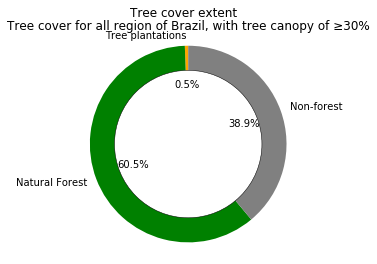

In [26]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
if adm0 and not adm1 and not adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {iso_to_countries[adm0]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and not adm2: 
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm1]}, "
                        f"with tree canopy of \u2265{threshold}%")
if adm0 and adm1 and adm2:
    dynamic_sentence = (f"Tree cover for {location.lower()} of {areaId_to_name[adm2]}, "
                        f"with tree canopy of \u2265{threshold}%")


if location in ['All Region']: 
    labels = 'Tree plantations', 'Natural Forest', 'Non-forest'
    sizes = [plantations, tree_cover_extent_2010 - plantations, total_area - tree_cover_extent_2010]
    colors = ['orange','green','grey']
else: 
    labels = 'Tree cover', 'Non-forest'
    sizes = [tree_cover_extent_2010, total_area - tree_cover_extent_2010]
    colors = ['green','grey']
    
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=colors)
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.suptitle('Tree cover extent')
plt.title(dynamic_sentence)
plt.show()

## FAO FOREST Widget

This widget should include 'FOREST COVER ' in the title - note the distinction, that the Hansen data relate to tree cover, and FAO relate to forest cover...

An FAO-based forest widget can be calcuated based on data in a carto table `https://wri-01.carto.com/tables/gfw2_countries`

It will take a little work, as the data stored in the carto table is % of primary, regenerated and planted forest. Therefore we must 1) get an area (ha) extent of the forest, 2) obtain the % values of various FAO forest statistics from the carto table, 3) derrive the real (ha) area of FAO forest for each category, and 4) get a value of absolute area of the country and subtract the values caluclated in step 3 from the total area to get non-forest. 

** Pie categories **

* Primary Forest
* Naturally Regenerated Forest
* Planted Forest
* Non-forest

**Notes** 

1. These data (and therefore this widget) is only avaiable at the NATIONAL (ADMIN 0) level. And should dissapear from the pages if any other area is selected.

1. These data have no threshold selection.

1. As these data are only national, we can simply rely on the `umd_nat_staging` table to provide areas directly, rather than needing to dynamically calculate the areas.

In [27]:
# For FAO data, only country (admin0) level data are avaiable. No other options on selector.

# Variables
adm0 = 'BRA'

In [28]:
# First, get the FAO data from a carto table

sql = ("SELECT fao.iso, fao.name,forest_planted, forest_primary, "
         "forest_regenerated, fao.forest_primary, fao.extent, a.land as area_ha "
         "FROM gfw2_countries as fao "
         "INNER JOIN umd_nat_staging as a "
         "ON fao.iso=a.iso "
         "WHERE fao.forest_primary is not null "
         f"AND fao.iso = '{adm0}' "
         "AND a.year = 2001 "
         "AND a.thresh = 30 "
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

fao_percent = r.json().get('rows')[0]

https://wri-01.carto.com/api/v2/sql?q=SELECT+fao.iso%2C+fao.name%2Cforest_planted%2C+forest_primary%2C+forest_regenerated%2C+fao.forest_primary%2C+fao.extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+is+not+null+AND+fao.iso+%3D+%27BRA%27+AND+a.year+%3D+2001+AND+a.thresh+%3D+30+ 

{'fields': {'area_ha': {'type': 'number'},
            'extent': {'type': 'number'},
            'forest_planted': {'type': 'number'},
            'forest_primary': {'type': 'number'},
            'forest_regenerated': {'type': 'number'},
            'iso': {'type': 'string'},
            'name': {'type': 'string'}},
 'rows': [{'area_ha': 853281125.672,
           'extent': 492968489,
           'forest_planted': 2,
           'forest_primary': 41,
           'forest_regenerated': 57,
           'iso': 'BRA',
           'name': 'Brazil'}],
 'time': 0.007,
 'total_rows': 1}


In [29]:
# How to calculate the statitics needed based on the CARTO responses

naturally_regenerated =  fao_percent['extent']/ 100 *  fao_percent['forest_regenerated']
primary_forest = fao_percent['extent']/100 *  fao_percent['forest_primary']
planted_forest = fao_percent['extent']/100 * fao_percent['forest_planted']
non_forest = fao_percent['area_ha'] - (naturally_regenerated + primary_forest + planted_forest)

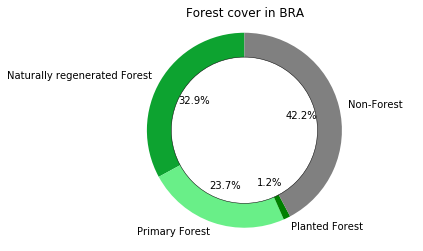

In [30]:
# FAO donut chart 
# NOTE - THE COLOURS ARE NOT NECESSARILY THOSE NEEDED FOR PRODUCTION
labels = ['Naturally regenerated Forest', 'Primary Forest', 'Planted Forest', 'Non-Forest']
sizes = [naturally_regenerated, primary_forest, planted_forest, non_forest]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['#0da330', '#69ef88','green','grey'])
ax1.axis('equal')
centre_circle = plt.Circle((0,0),0.75,color='black', fc='white',linewidth=0.5)
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
plt.title(f'Forest cover in {adm0}')
plt.show()

In [31]:
## RANK ALL COUNTRIES RELATIVE AMOUNT OF PRIMARY FOREST in 2015 and report that value for a dynamic sentence

sql = ("WITH mytable AS (SELECT fao.iso, fao.name, fao.forest_primary, fao.extent forest_extent, a.land as area_ha "
"FROM gfw2_countries as fao "
"INNER JOIN umd_nat_staging as a "
"ON fao.iso=a.iso "
"WHERE fao.forest_primary > 0 "
"AND a.year = 2001 "
"AND a.thresh = 30), "
"rank AS ( "
"SELECT forest_extent * (forest_primary/100)/area_ha * 100 as percent_primary ,iso "
"from mytable "
"ORDER BY percent_primary DESC), "
f"item as (select percent_primary from rank where iso = '{adm0}') "
"select count(*) as rank "
"from rank "
"WHERE percent_primary > (select percent_primary from item) ")

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

rank = r.json().get('rows')[0].get('rank')
print(rank)

https://wri-01.carto.com/api/v2/sql?q=WITH+mytable+AS+%28SELECT+fao.iso%2C+fao.name%2C+fao.forest_primary%2C+fao.extent+forest_extent%2C+a.land+as+area_ha+FROM+gfw2_countries+as+fao+INNER+JOIN+umd_nat_staging+as+a+ON+fao.iso%3Da.iso+WHERE+fao.forest_primary+%3E+0+AND+a.year+%3D+2001+AND+a.thresh+%3D+30%29%2C+rank+AS+%28+SELECT+forest_extent+%2A+%28forest_primary%2F100%29%2Farea_ha+%2A+100+as+percent_primary+%2Ciso+from+mytable+ORDER+BY+percent_primary+DESC%29%2C+item+as+%28select+percent_primary+from+rank+where+iso+%3D+%27BRA%27%29+select+count%28%2A%29+as+rank+from+rank+WHERE+percent_primary+%3E+%28select+percent_primary+from+item%29+ 

{'fields': {'rank': {'type': 'number'}},
 'rows': [{'rank': 27}],
 'time': 0.038,
 'total_rows': 1}
27


In [32]:
# Dyanmic sentence for FAO plot

print(f"FAO data from 2015 shows that {iso_to_countries[adm0]} is ", end="")

if  non_forest/fao_percent['area_ha'] > 0.5:
    print('mostly non-forest. ', end="")
else:
    print('mostly forest. ',end="")

if primary_forest > 0:
    print(f"Primary forest occupies {primary_forest/fao_percent['area_ha']*100:3.1f}% of the country. ", end="")
    print(f"This gives {iso_to_countries[adm0]} a rank of {rank}th out of 110 countries in terms of ", end="")
    print("its relative amount of primary forest.")

FAO data from 2015 shows that Brazil is mostly forest. Primary forest occupies 23.7% of the country. This gives Brazil a rank of 27th out of 110 countries in terms of its relative amount of primary forest.


## TREE COVER LOSS WIDGET 

The UMD/Hansen Tree cover loss widget should be a bar chart, with time as the x-axis, and loss (ha) as the y-axis, on hover it should show the year, ha loss, and % loss relative to 2000 tree cover extent *for the data table of interest*.

** Notes ** 

* Loss data tables have loss units in both area (ha) and emissions (t co2/ha). The emissions units will only be used in the loss widget to add contextual info to the dynamic sentence.

* It is probably best to always request the full time period of data from the table, and then subset it client-side, as we will always need to know the last year of loss to construct the dynamic sentence.

* In settings, the users should be able to change the data sources, when they do you will need to query different data tables both for calculating loss and extent (to calculate relative loss):
    - All region (default) view: gadm28 table
    - all other data tables currently created should be selectable too
    
*more info - not needed for front-end devs*
- for refrence in testing adm0 = BRA, adm1 = 12, adm2 = 1434 is Mato Grosso, Cáceres


** WHen plantations are selected the user should see a stacked bar chart  from 2013 onwards **
More details of this to follow below.


In [33]:
# Variables

threshold=30
adm0 = 'BRA'
adm1 = None
adm2 = None
start=2000
end=2016
location = "All Region"

In [34]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name')

In [35]:
def loss_queries(p_name, adm0, adm1=None, adm2=None, threshold=30):
    if adm2:
        print(f'Request for adm2 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND adm2 = {adm2} "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql
    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql
    elif adm0:
        print('Request for  adm0 area')
        sql = (f"SELECT polyname, year_data.year as year, "
               f"SUM(year_data.area_loss) as area, "
               f"SUM(year_data.emissions) as emissions "
               f"FROM data "
               f"WHERE polyname = '{p_name}' " 
               f"AND iso = '{adm0}' "
               f"AND thresh= {threshold} "
               f"GROUP BY polyname, iso, nested(year_data.year)")
        return sql



Loss on hover should show % loss relative to Tree cover extent of the location selected in the year 2010. I.e. if someone is interested in the 'All region' default view, then the loss should come from the `gadm28 loss` table, and the extent (to calculate the relative loss) should come from the `gadm28 extent` table.

Therefore we must calculate loss % also, for this we will need the tree cover extent data too.

In [36]:
# First, get the extent of tree cover over your area of interest (to work out relative loss)
sql = extent_queries(p_name=polynames[location], adm0=adm0, 
                   adm1=adm1, adm2=adm2, threshold=threshold)    
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())
y2010_relative_extent = r.json().get('data')[0].get('total_area')

Request for  adm0 area
SELECT SUM(area_extent) as value, SUM(area_gadm28) as total_area FROM data WHERE iso = 'BRA' AND thresh = 30 AND polyname = 'gadm28'
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b46

In [37]:
#ds = '499682b1-3174-493f-ba1a-368b4636708e'
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

print(adm0)

# Next, get the loss data grouped by year
sql = loss_queries(p_name=polynames[location], adm0=adm0, 
                   adm1=adm1, adm2=adm2, threshold=threshold)    
print(sql) # loss query
properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())


# # Extract the year, and loss in hectares, and emissions units, and calculate the relative loss in %
d = {}
for row in r.json().get('data'):
    tmp_yr = float(row.get('year'))
    if tmp_yr > 2000:
        try:
            tmp_area = float(row.get('area'))
        except:
            tmp_area = None
            
        try:
            tmp_area_pcnt = (tmp_area / y2010_relative_extent) * 100
        except:
            tmp_area_pcnt = None
            
        try:
            tmp_emiss = float(row.get('emissions'))
        except:
            tmp_emiss = None
            
        d[int(tmp_yr)] = {'area_ha': tmp_area,
                              'area_%': tmp_area_pcnt,
                              'emissions': tmp_emiss,
                               }
pprint(d)

BRA
Request for  adm0 area
SELECT polyname, year_data.year as year, SUM(year_data.area_loss) as area, SUM(year_data.emissions) as emissions FROM data WHERE polyname = 'gadm28' AND iso = 'BRA' AND thresh= 30 GROUP BY polyname, iso, nested(year_data.year)
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.emissions%29+as+emissions+FROM+data+WHERE+polyname+%3D+%27gadm28%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+polyname%2C+iso%2C+nested%28year_data.year%29
Status: 200
{'data': [{'area': 2746361.4890696183,
           'emissions': 451665397.0006001,
           'iso': 'BRA',
           'polyname': 'gadm28',
           'year': 2001},
          {'area': 3507049.430043675,
           'emissions': 599107237.3975263,
           'iso': 'BRA',
           'polyname': 'gadm28',
           'year': 2002},
          {'area': 3248526.7289099023,
      

Use the `start` and `end` variables to filter the time-range on the front-end.

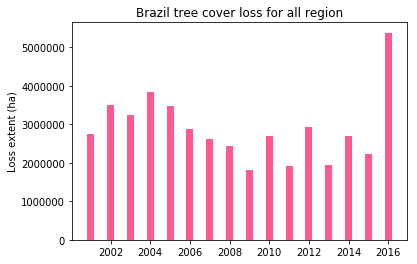

In [38]:
if adm0 and not adm1 and not adm2:
    dynamic_title = (f'{iso_to_countries[adm0]} tree cover loss for {location.lower()}')
if adm0 and adm1 and not adm2: 
    dynamic_title = (f"{areaId_to_name[adm1]} tree cover loss for {location.lower()}")
if adm0 and adm1 and adm2:
    dynamic_title = (f"{areaId_to_name[adm2]} tree cover loss for {location.lower()}")


loss = []
for val in d.values():
    if val.get('area_ha'):
        loss.append(val.get('area_ha'))
    else:
        loss.append(0)

years = d.keys()
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(years, loss, width, color='#FE5A8D')


# add some text for labels, title and axes ticks
ax.set_ylabel('Loss extent (ha)')
ax.set_title(dynamic_title)
plt.show()

#### Dynamic sentence 

For the loss widget we also need a dynamic sentence.

In [39]:
for year in d:
    print(year, d.get(year).get('emissions'), d.get(year).get('area_ha'))

2001 451665397.0006001 2746361.4890696183
2002 599107237.3975263 3507049.430043675
2003 540574861.4785872 3248526.7289099023
2004 676408980.2036796 3848770.7972362638
2005 644553412.0320137 3486562.714630291
2006 513807720.2924354 2876804.669658102
2007 437504684.6362488 2621820.242933862
2008 421136841.3216598 2444308.1962688714
2009 309401955.17921805 1817901.2345727086
2010 455313700.8952615 2688896.1758544967
2011 323015090.3335359 1923363.68953944
2012 464007720.51890945 2918633.138893433
2013 299307098.087373 1945506.2521234453
2014 414300626.2159879 2693134.2983764634
2015 347409489.11158633 2222772.419181913
2016 961585493.266664 5378844.035288975


In [40]:
# First find total emissions, and loss, and also the last year of emissions and loss

total_emissions = 0
total_loss = 0
for year in d:
    total_loss += d.get(year).get('area_ha')
    total_emissions += d.get(year).get('emissions')

print([total_emissions, total_loss])

[7859100307.971289, 46369255.51258146]


In [41]:
# Dynamic sentence construction

if adm0 and not adm1 and not adm2:
    print(f"Between {start} and {end}, {iso_to_countries[adm0]} ({location.lower()}) ", end="")
if adm0 and adm1 and not adm2: 
    print(f"Between {start} and {end},  {location} of {areaId_to_name[adm1].lower()} ", end="")
if adm0 and adm1 and adm2:
    print(f"Between {start} and {end}, {location} of {areaId_to_name[adm2].lower()} ", end="")
    
print(f"lost {total_loss:,.0f} ha of tree cover: ", end="")
print(f"This loss is equal to {total_loss / y2010_relative_extent * 100:3.2f}% of the total ", end="")
print(f"{location.lower()} tree cover extent in 2010, ", end="")
print(f"and equivalent to {total_emissions:,.0f} tonnes of CO\u2082 emissions. ", end="")

Between 2000 and 2016, Brazil (all region) lost 46,369,256 ha of tree cover: This loss is equal to 5.45% of the total all region tree cover extent in 2010, and equivalent to 7,859,100,308 tonnes of CO₂ emissions. 

## HEADER DYNAMIC SENTENCE

The page header needs to contain a dynamic sentence; this sentence is built from the same data tables (and most of the same queries) that we have already used. (Which is why I am describing it here, rather than at the start of the notebook.)

The sentence should be able to account for edge cases where no loss occured (as people will end up looking at admin 2 areas) which may be relativley small, and possibly have no loss.

Be prepared for the need to increase the complexity/comprehensivness of the header sentence over time.

In [42]:
def extract_loss(json_data, last_year=2016):
    """Grab the last loss year of data for area and emissions"""
    for row in json_data:
        if row.get('year') == last_year:
            last_loss = row.get('area')
            last_emissions = row.get('emissions')
    return {'area':last_loss, 'emissions':last_emissions}

In [43]:
last_year = 2016
threshold = 30
adm0 = 'BRA'
adm1 = None
adm2 = None

In [44]:
# get a human readable {id: name} json for either admin 1 or 2 level as needed:

areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [45]:
# Get the plantation last year data for the region of interest

sql = loss_queries(p_name=polynames['Plantations'], adm0=adm0, adm1=adm1, adm2=adm2,
             threshold=threshold)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantation_loss_json = r.json().get('data')
plantation_values = extract_loss(plantation_loss_json, last_year=last_year)
print(plantation_values)

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.emissions%29+as+emissions+FROM+data+WHERE+polyname+%3D+%27plantations%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+polyname%2C+iso%2C+nested%28year_data.year%29
Status: 200
{'area': 154472.9096068442, 'emissions': 16645906.638489366}


In [46]:
# Get the gadm28 loss 

sql = loss_queries(p_name=polynames['All Region'], adm0=adm0, adm1=adm1, adm2=adm2,
             threshold=threshold)

properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

plantation_loss_json = r.json().get('data')
gadm28_values = extract_loss(plantation_loss_json, last_year=last_year)
print(gadm28_values)

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+polyname%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area%2C+SUM%28year_data.emissions%29+as+emissions+FROM+data+WHERE+polyname+%3D+%27gadm28%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+polyname%2C+iso%2C+nested%28year_data.year%29
Status: 200
{'area': 5378844.035288975, 'emissions': 961585493.266664}


In [47]:
url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

sql = extent_queries(p_name=polynames[location], adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

total_area =r.json().get('data')[0].get('total_area')
print(total_area)

Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}
850033236.0091553


In [48]:
# Get 2010 tree cover extent of selected area from gadm28 table 

sql = extent_queries(p_name=polynames[location],
                     adm0=adm0, adm1=adm1, adm2=adm2, threshold=threshold)
r = requests.get(url, params = {"sql": sql})

print(r.url)
print(f'Status: {r.status_code}')
pprint(r.json())

try:
    tree_cover_extent_2010 = r.json().get('data')[0].get('value')
except:
    tree_cover_extent_2010 = 0.0
print(f"\n{adm0} {adm1} {adm2} Gadm28 Tree cover extent = {tree_cover_extent_2010} ha")


Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27
Status: 200
{'data': [{'total_area': 850033236.0091553, 'value': 519187505.155631}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_extent%29%20as%20value%2C%20SUM%28area_gadm28%29%20as%20total_area%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20thresh%20%3D%2030%20AND%20polyname%20%3D%20%27gadm28%27'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}

BRA None None Gadm28 Tree cover extent = 519187505.155631 ha


In [49]:
# DYNAMIC SENTENCE

if adm0 and not adm1 and not adm2:
    print(f"In 2010, {iso_to_countries[adm0]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")     
if adm0 and adm1 and not adm2: 
    print(f"In 2010, {areaId_to_name[adm1]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")
if adm0 and adm1 and adm2:
    print(f"In 2010, {areaId_to_name[adm2]} had {int(tree_cover_extent_2010):,.0f} ha of tree cover", end="")

percent_cover = tree_cover_extent_2010/total_area*100
if percent_cover > 0:
    print(f", extending over {percent_cover:3.1f}% of its land area. ", end="")
else:
    print(". ")

# beware we could have areas with no plantations
try:
    loss_area = int(gadm28_values['area'] - plantation_values['area'])
except:
    loss_area = 0
    
print(f"In {last_year}, ",end="")

if loss_area > 0:
    print(f"it lost {loss_area:,.0f} ha "
          "of forest excluding tree plantations, equivalent to "
          f"{int(gadm28_values['emissions'] - plantation_values['emissions']):,.0f} "
          "tonnes of CO\u2082 of emissions.")
else:
    print("it lost no tree cover (excluding tree plantations).")

In 2010, Brazil had 519,187,505 ha of tree cover, extending over 61.1% of its land area. In 2016, it lost 5,224,371 ha of forest excluding tree plantations, equivalent to 944,939,586 tonnes of CO₂ of emissions.


# Tree Cover gain widget

1. Widgets made from a dynamic sentence
2. User Variables (admin0 to admin1 and location)

** LOCATION Area Selectors **

    - All region
    - Biodiversity Hotspots
    - Protected Areas
    - Plantations
    - Managed Forests
    - Primary Forests
    - Intact Forests (2000/2013)

** Notes **

- AOI (area of interest) is the gadm region (admin0-2)
- location is the subset of that (i.e protected areas)
- Threshold is not a variable in this widget (it should be hardcoded in the queries and must be set to `thresh = 0`)

In [54]:
# Variables
adm0 = 'BRA'
adm1 = None
adm2 = None
p_name = "All Region"

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"

In [55]:
# get admin 1 or 2 level human-readable name info as needed:
areaId_to_name = None
if adm2:
    tmp = get_admin2_json(iso=adm0, adm1=adm1)
    areaId_to_name ={}
    for row in tmp:
        areaId_to_name[row.get('adm2')] = row.get('name')
if adm1 and not adm2:
    tmp = get_admin1_json(iso=adm0)
    areaId_to_name={}
    for row in tmp:
        areaId_to_name[row.get('adm1')] = row.get('name') 

In [56]:
#GAIN QUERY

def gain_query(p_name, adm0, adm1=None, adm2 = None):
    """Queries for the gain tables. Note, threshold must be hardcoded to 0
        and that will not change.
    """
    if adm2:
        print('Request for  adm2 area')
        sql = (f"SELECT area_gain as value FROM data WHERE iso = '{adm0}' "
               f"AND polyname = '{p_name}' "
               f"AND adm1 = {adm1} AND adm2 = {adm2} AND thresh = 0") 

    elif adm1:
        print('Request for  adm1 area')
        sql = (f"SELECT SUM(area_gain) as value FROM data WHERE iso = '{adm0}' "
               f"AND polyname = '{p_name}' "
               f"AND adm1 = {adm1} AND thresh = 0")
    elif adm0:
        print('Request for adm0 area')
        sql = (f"SELECT SUM(area_gain) as value FROM data WHERE iso = '{adm0}' "
               f"AND polyname = '{p_name}' "
               f"AND thresh = 0")
    return sql


In [57]:
# gain query
sql = gain_query(p_name=polynames[location], adm0=adm0, adm1=adm1, adm2=adm2)
r1 = requests.get(url, params = {"sql": sql})

try:
    tree_cover_gain_2010 = r1.json().get('data')[0].get('value')
except:
    tree_cover_gain_2010 = 0.0
    
print(r1.url)    
pprint(r1.json())


# Total Extent query
sql = extent_queries(p_name=polynames[location], adm0=adm0, adm1=adm1, adm2=adm2)
r2 = requests.get(url, params = {"sql": sql})

try:
    extent_area = r2.json().get('data')[0].get('value')
except:
    extent_area = 0.0

print(r2.url)
pprint(r2.json())

area_percent = (100 * tree_cover_gain_2010 / extent_area)

Request for adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_gain%29+as+value+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+polyname+%3D+%27gadm28%27+AND+thresh+%3D+0
{'data': [{'value': 106094881256.90405}],
 'meta': {'cloneUrl': {'body': {'dataset': {'application': ['your', 'apps'],
                                            'datasetUrl': '/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT%20SUM%28area_gain%29%20as%20value%20FROM%20data%20WHERE%20iso%20%3D%20%27BRA%27%20AND%20polyname%20%3D%20%27gadm28%27%20AND%20thresh%20%3D%200'}},
                       'http_method': 'POST',
                       'url': '/v1/dataset/499682b1-3174-493f-ba1a-368b4636708e/clone'}}}
Request for  adm0 area
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+SUM%28area_extent%29+as+value%2C+SUM%28area_gadm28%29+as+total_area+FROM+data+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND

In [52]:
#Dynamic sentence

# we may need to modify the way we describe the location to fit gramatically
if location == 'All Region':
    region_phrase = 'region-wide'
else:
    region_phrase = 'in ' + location.lower()


print(f"From 2001 to 2012, ", end="")

if(not adm1 and not adm2):
    print(f"{iso_to_countries[adm0]} gained {total_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ",end="")
    print(f"increase relative to 2010 tree cover extent.", end="")
elif(not adm2):
    print(f"{areaId_to_name[adm1]} gained {total_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ",end="")
    print(f"increase relative to 2010 tree cover extent.", end="")
else:
    print(f"{areaId_to_name[adm2]} gained {total_area:,.0f} ha of tree cover ", end="")
    print(f"{region_phrase}, equivalent to a {area_percent}% ", end="")
    print(f"increase relative to 2010 tree cover extent.", end="")


From 2001 to 2012, Brazil gained 7,644,119,951 ha of tree cover region-wide, equivalent to a 20434.790938410813% increase relative to 2010 tree cover extent.

# Rate of Reforestation widget

Dynamic Sentence based on FAO data in a Carto table. Only works for admin-0 (countries).


e.g. dynamic sentences:

"Between `X` and `Y` years, the rate of reforestation in `country name` was `X` ha/year."


** Options**

Users should be able to select period from a dropdown menu in the settings:
* Period: ['1990–2000', '2000–2005', '2005–2010', '2010–2015']

** Notes**

- Default should be the most recent period (`2010–2015`).
- The value that comes back from the query is kha not ha : i.e. it is in ha/1000 by default.

In [ ]:
# Human readable option for the Period selector, and a key that it should relate to for its query.
fao_periods = {'1990–2000': 1990, '2000–2005':2000, '2005–2010':2005, '2010–2015':2010}


# Variables
adm0 = 'GBR'
period = '2010–2015'

In [ ]:
# First, get the FAO data from a carto table. Note that extent is multiplied by 1000.

sql = ("SELECT country AS iso, name, year, reforest AS rate, forest*1000 AS extent "
         "FROM table_1_forest_area_and_characteristics as fao "
         f"WHERE fao.year = {fao_periods[period]} "
         f"AND fao.country = '{adm0}'"
        )

account = 'wri-01'
urlCarto = "https://{0}.carto.com/api/v2/sql".format(account)

sql = {"q": sql}
r = requests.get(urlCarto, params=sql)
print(r.url,'\n')
pprint(r.json())

data = r.json().get('rows')[0]

In [ ]:
#Dynamic sentence

print(f"From {period}, the rate of reforestation in {data['name']} was {data['rate']*1000:,.0f} ha/year. ", end="")

# "Where are Forests Located?" Widget

Displayed data, ordered by DESC area:

1. Admin-2 or -1 name
2. % of total extent
3. Area of extent (ha)

User Variables:

1. Threshold Density
2. Hanson extent, IFL2013, Plantations or Intact forest
3. Admin-0 and -1 region


In [11]:
#DATASET (CONTAINS EVERYTHING NOW)

ds = '499682b1-3174-493f-ba1a-368b4636708e'  # ADMIN 2 level data

In [43]:
# VARIABLES

p_name = 'gadm28'   # 'plantations', 'ifl_2013', or 'primary_forests'... here 'gadm28'=default
threshold = 0       # 0,10,15,20,25,30,50,75,100 

adm0 = 'BRA'
adm1 = 20             # To rank admin 1 areas, set to None
                      # To rank admin 2 areas, specify an admin 1 level

In [50]:
# Returns json object containing admin-codes, total area and extent (both in ha)
# If adm1 is not specified, it returns the total values for each adm1 region
# Else, returns the adm2 values within that adm1 region
# You may also specify a polyname (intersecting area) e.g. 'extent and % of plantations only'
# By default polyname is 'gadm28' (all forest extent)

def aggregated_extent_queries(adm0, adm1=None, polyname='gadm28', thresh=30):
    """If an admin0 or admin 1 area is requestd, use precalulated tables.
       If an admin2 is requested, calculate the area from the geometry.
    """
    if adm0 and not adm1:
        print('Request for adm1 areas')
        sql = ("SELECT adm1, sum(area_extent) as value, sum(area_gadm28) as total_area "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {threshold} "
               f"AND polyname = '{polyname}' "
               f"GROUP BY adm1 "
               f"ORDER BY adm1")
        
    elif adm0 and adm1:
        print('Request for adm2 areas')
        sql = ("SELECT adm2, area_extent as value, area_gadm28 as total_area "
                f"FROM {ds} "
                f"WHERE iso = '{adm0}' "
                f"AND thresh = {threshold} "
                f"AND polyname = '{polyname}' "
                f"AND adm1 = '{adm1}' ")

    return sql

In [48]:
# Takes the data from the above api call and generates a list containing the relevant data: 
# Admin-Code, Forest Extent Area, Percentage of Admin region
# NOTE that 'area_percent' is the forest extent area relative to teh area of its admin-region.

def data_output(data, adm1=None):
    
    output = []
    
    if adm1:

        for d in range(0, len(data)):
            tmp_ = {

                'adm2': data[d]['adm2'],
                'area_percent': (100*data[d]['value']/data[d]['total_area']),
                'area_ha': data[d]['value']

            }
            output.append(tmp_)

        return output
        
    else:

        for d in range(0, len(data)):
            tmp_ = {

                'adm1': data[d]['adm1'],
                'area_percent': 100*data[d]['value']/data[d]['total_area'],
                'area_ha': data[d]['value']

            }
            output.append(tmp_)

        return output

In [49]:
# Example sql and returned data


url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
sql = aggregated_extent_queries(adm0, adm1, p_name, threshold)


properties = {"sql": sql}
r = requests.get(url, params = properties)
print(r.url)
print(f'Status: {r.status_code}')

data = r.json()['data']

data[0]

Request for adm2 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm2%2C+area_extent+as+value%2C+area_gadm28+as+total_area+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+0+AND+polyname+%3D+%27gadm28%27+AND+adm1+%3D+%2720%27+
Status: 200


{'_id': 'AWAxoA8iVdtBxrrIAfPp',
 'adm2': 3813,
 'total_area': 13505.584152399999,
 'value': 500.310229765}

In [53]:
# After generating list return wanted metrics
# (NOTE! This is not sorted.)

output = data_output(data, adm1)
output[0]


{'adm2': 3813, 'area_ha': 500.310229765, 'area_percent': 3.704469381845233}

### Dynamic Sentence for "Where are Forests Located?" Widget

1. Returns the no of regions responsible for >50% of the regions tree cover loss (adm1)
     - or, the loss (%) that the top 10% of regions are responsible for (adm2)
2. Max and Min loss (%) in that region
3. Average loss (%) that each region contributes to the total

In [55]:
#Sort regions by area of loss (DESC)

newlist = sorted(output, key=lambda k: k['area_ha'], reverse=True) 
newlist[0]

{'adm2': 3741, 'area_ha': 62581.395211, 'area_percent': 29.641481836547246}

In [56]:
#Calculate total three cover loss at this threshold
total = 0

for i in range(0,len(output)):
    total += newlist[i]['area_ha']

In [57]:
# Calculate % loss for e h region (relative to total loss). Also filters out incorrect/duplicated data

correct_list = []

if adm1:
    for i in range(0,len(output)):

        if(i != 0 and newlist[i]['adm2'] != newlist[i-1]['adm2']):
            correct_list.append(100*newlist[i]['area_ha']/total)

        elif i == 0:
            correct_list.append(100*newlist[i]['area_ha']/total)
else:            
    for i in range(0,len(output)):
    
        if(i != 0 and newlist[i]['adm1'] != newlist[i-1]['adm1']):
            correct_list.append(100*newlist[i]['area_ha']/total)

        elif i == 0:
            correct_list.append(100*newlist[i]['area_ha']/total)

In [58]:
#Calculate the mean loss

mean=0
for i in range(0, len(correct_list)):
    
    mean += correct_list[i]
    
mean = mean/len(correct_list)

In [59]:
# Percentile calcs: how man regions are responsible for >50% loss?
# (x is no. of adm regions. t is total treecover loss in %)

x=1
flag = False

if adm1:
    
    t=0

    for l in range(0, int(len(correct_list)/10)):

        t += correct_list[l]
        
    print(t)
            
else:
      
    while not flag:

        t=0

        for l in range(0,x):

            t += correct_list[l]

        if t > 50:
            break
        else:
            x += 1

35.758207809700316


In [60]:
#Loss Stats
loss_stats = { 'max': correct_list[0], 'min': correct_list[len(correct_list)-1], 'ave': mean}
loss_stats

{'ave': 0.5988023952095815,
 'max': 4.479464389928271,
 'min': 0.017770187100259984}

In [61]:
#Dynamic sentence. For adm2.

if adm1:
    
    print(f"The top ten percent of sub-regions were responsible for {t:,.0f}% of {adm1}'s total treecover loss. ", end="")
    print(f"The largest loss in a single sub-region was {loss_stats['max']:,.0f}%, ", end="")
    print(f"with sub-regions each contributing {loss_stats['ave']:,.1f}% loss on average.", end="")
    
else:
    
    #Dynamic sentence. For adm1.

    print(f"Only {x} regions were responsible for more than half {t:,.0f}%) of {iso}'s treecover loss. ", end="")
    print(f"The largest loss in a single region was {loss_stats['max']:,.0f}%, ", end="")
    print(f"with regions each contributing {loss_stats['ave']:,.1f}% loss on average.", end="")

The top ten percent of sub-regions were responsible for 36% of 20's total treecover loss. The largest loss in a single sub-region was 4%, with sub-regions each contributing 0.6% loss on average.

# WHERE IS THE MOST LOSS OCCURING? Widget

Displays a pie chart and rank list / key for forest cover loss in each admin-region. On hover the pie chart segments display the loss, in ha, for that region between 2001-2016.

The piechart should display data for the top-10 admin regions, and group the rest together as 'Other Districts'.

Data:

1. admn-1 and -2 codes
2. forest loss
3. extent

User Variables:

1. year range
2. unit (ha/% of regions extent)
3. locations (all)
4. canopy threshold


In [62]:
#DATASET (CONTAINS EVERYTHING NOW)

ds = '499682b1-3174-493f-ba1a-368b4636708e'  # ADMIN 2 level data

In [63]:
# VARIABLES

p_name = 'gadm28'     # 'gadm28'=default, all polynames should be accessible
thresh = 30            # 0,10,15,20,25,30,50,75,100 

adm0 = 'BRA'
adm1 = None             # To rank admin 1 areas, set to None
                      # To rank admin 2 areas, specify an admin 1 level
    
start_year = 2001     #Users can select a year range: min=2001, max=2016
end_year = 2016

In [64]:
def loss_by_region(p_name, adm0, adm1=None, threshold=30):
    if adm1:
        print('Request for  adm2 areas')
        sql = (f"SELECT adm2, year_data.year as year, "
               f"SUM(year_data.area_loss) as area_loss, "
               f"FROM data "
               f"WHERE polyname = '{p_name}' "
               f"AND iso = '{adm0}' "
               f"AND adm1 = {adm1} "
               f"AND thresh= {threshold} "
               f"GROUP BY adm2, nested(year_data.year)"
               f"ORDER BY adm2")
        return sql
    elif adm0:
        print('Request for  adm1 areas')
        sql = (f"SELECT adm1, year_data.year as year, "
               f"SUM(year_data.area_loss) as area_loss, "
               f"FROM data "
               f"WHERE polyname = '{p_name}' " 
               f"AND iso = '{adm0}' "
               f"AND thresh= {threshold} "
               f"GROUP BY adm1, nested(year_data.year)"
               f"ORDER BY adm1")
        return sql

def aggregated_extent_queries(adm0, adm1=None, polyname='gadm28', thresh=30):
    """If an admin0 or admin 1 area is requestd, use precalulated tables.
       If an admin2 is requested, calculate the area from the geometry.
    """
    if adm0 and not adm1:
        print('Request for adm1 areas')
        sql = ("SELECT adm1, sum(area_extent) as extent, sum(area_gadm28) as total "
               f"FROM {ds} "
               f"WHERE iso = '{adm0}' "
               f"AND thresh = {thresh} "
               f"AND polyname = '{polyname}' "
               f"GROUP BY adm1 "
               f"ORDER BY adm1")
        
    elif adm0 and adm1:
        print('Request for adm2 areas')
        sql = ("SELECT adm2, area_extent as extent, area_gadm28 as total "
                f"FROM {ds} "
                f"WHERE iso = '{adm0}' "
                f"AND thresh = {thresh} "
                f"AND polyname = '{polyname}' "
                f"AND adm1 = '{adm1}' ")

    return sql

In [65]:
def output_by_date_range(adm1, extent_data, loss_data, start_year=2001, end_year=2016):

    output = []
    
    year_dict = {     # Gives an index value for each year so that they can easily be iterated over
    
        2001: 0,
        2002: 1,
        2003: 2,
        2004: 3,
        2005: 4,
        2006: 5,
        2007: 6,
        2008: 7,
        2009: 8,
        2010: 9,
        2011: 10,
        2012: 11,
        2013: 12,
        2014: 13,
        2015: 14,
        2016: 15 

    }

    output = []
    
    max_size = int(len(loss_data)/16)  # Number of distinct admin regions

    for r in range(0, max_size):    # Outer loop runs over each distinct admin region using max_size

        tmp_loss = 0                                                  # Inner loop runs over each year the user
                                                                      # has selected within an admin region
        for y in range(year_dict[start_year],year_dict[end_year]+1):  # e.g. from start_year to end_year
                
            c = (16*r)+y                                  # c is just a looping index
            
            if len(loss_data[c].keys()) == 3:             # Checks data is present, if not then skip!

                tmp_loss += loss_data[c]['area_loss']     # Adds loss over each year in year range

        if adm1:

            tmp_output = {

                'adm2': loss_data[c]['adm2'],
                'loss_total': tmp_loss,
                'percent': 100*tmp_loss/extent_data[r]['extent']
            }

        else:

            tmp_output = {

                'adm1': loss_data[c]['adm1'],
                'loss_total': tmp_loss,
                'percent': 100*tmp_loss/extent_data[r]['extent']
            }

        output.append(tmp_output)

    return output

In [66]:
# Query for loss

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
loss_sql = loss_by_region(p_name, adm0, adm1, thresh)

properties = {"sql": loss_sql}
rl = requests.get(url, params = properties)
print(rl.url)
print(f'Status: {rl.status_code}')

loss_data = rl.json()['data']

#Example data structure
loss_data[0]

Request for  adm1 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1%2C+year_data.year+as+year%2C+SUM%28year_data.area_loss%29+as+area_loss%2C+FROM+data+WHERE+polyname+%3D+%27gadm28%27+AND+iso+%3D+%27BRA%27+AND+thresh%3D+30+GROUP+BY+adm1%2C+nested%28year_data.year%29ORDER+BY+adm1
Status: 200


{'adm1': 1, 'area_loss': 67309.77182006836, 'year': 2001}

In [67]:
#Query for extent (to calculate percentages)

url = f"https://production-api.globalforestwatch.org/v1/query/{ds}"
extent_sql = aggregated_extent_queries(adm0, adm1, p_name, thresh)

properties = {"sql": extent_sql}
re = requests.get(url, params = properties)
print(re.url)
print(f'Status: {re.status_code}')

extent_data = re.json()['data']

#Example data structure
extent_data[0]

Request for adm1 areas
https://production-api.globalforestwatch.org/v1/query/499682b1-3174-493f-ba1a-368b4636708e?sql=SELECT+adm1%2C+sum%28area_extent%29+as+extent%2C+sum%28area_gadm28%29+as+total+FROM+499682b1-3174-493f-ba1a-368b4636708e+WHERE+iso+%3D+%27BRA%27+AND+thresh+%3D+30+AND+polyname+%3D+%27gadm28%27+GROUP+BY+adm1+ORDER+BY+adm1
Status: 200


{'adm1': 1, 'extent': 14379381.2578125, 'total': 15273286.984375}

In [68]:
#Output data in usable format

output = output_by_date_range(adm1, extent_data, loss_data, start_year, end_year)

#Example final ouput
output[0]

{'adm1': 1, 'loss_total': 970442.380279541, 'percent': 6.7488465802538435}